We first uploaded and performed some basic cleaning on our data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mutual_info_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# import telco dataset into a pandas data frame
df_telco = pd.read_csv('telco_churn.csv')

# transform the column TotalCharges into a numeric data type
df_telco['TotalCharges'] = pd.to_numeric(df_telco['TotalCharges'], errors='coerce')
# drop observations with null values
df_telco.dropna(inplace=True)
# drop the customerID column from the dataset
df_telco.drop(columns='customerID', inplace=True)
# remove (automatic) from payment method names
df_telco['PaymentMethod'] = df_telco['PaymentMethod'].str.replace(' (automatic)', '', regex=False)

df_telco

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer,42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No
7039,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card,103.20,7362.90,No
7040,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.60,Yes


Then, we calculated the mutual information score to determine which columns had the least relation with churn.

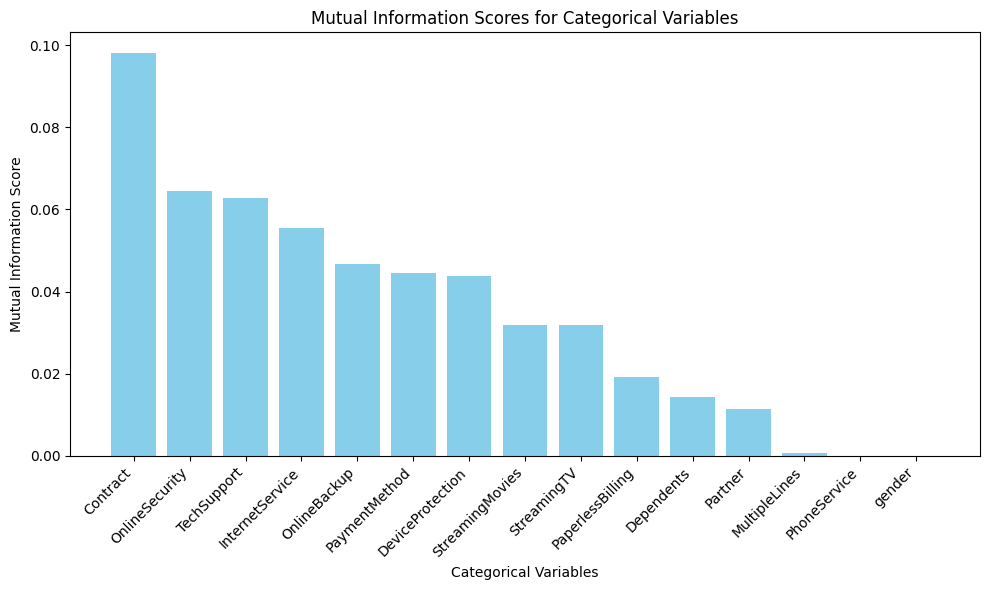

In [ ]:
# function that computes the mutual infomation score between a categorical serie and the column Churn
def compute_mutual_information(categorical_serie):
    return mutual_info_score(categorical_serie, df_telco.Churn)

# select categorial variables excluding the response variable
categorical_variables = df_telco.select_dtypes(include=object).drop('Churn', axis=1)

# compute the mutual information score between each categorical variable and the target
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(feature_importance.index, feature_importance.values, color='skyblue')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Categorical Variables')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores for Categorical Variables')
plt.tight_layout()
plt.show()

We graphed a few categories for our presentation.

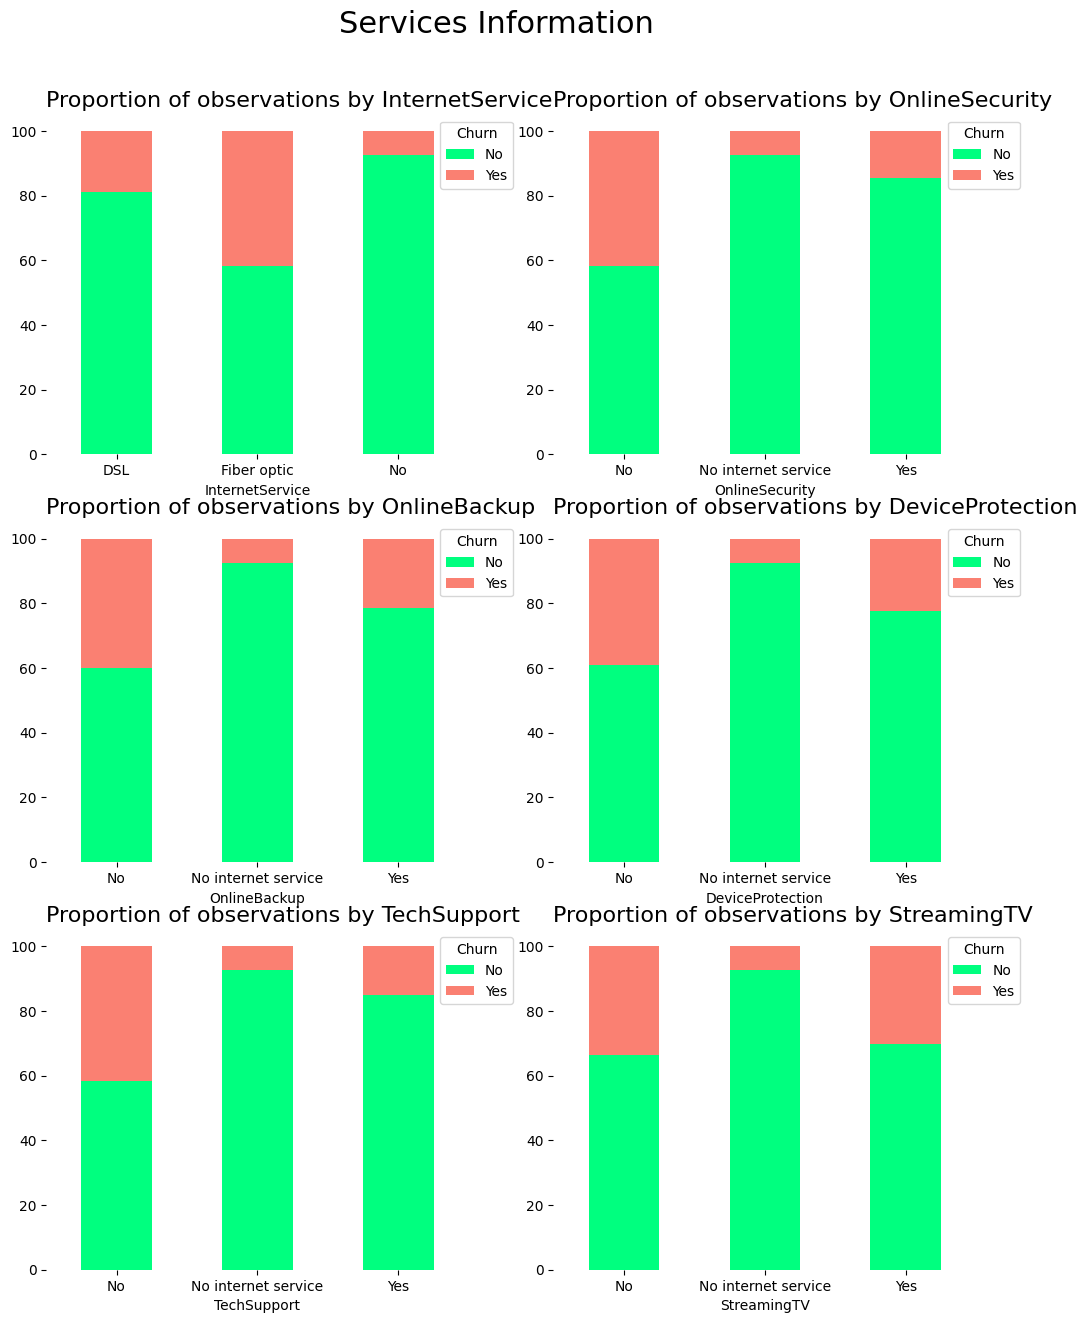

In [ ]:
def percentage_stacked_plot(columns_to_plot, super_title):
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows))
    fig.suptitle(super_title, fontsize=22,  y=.95)


    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df_telco[column], df_telco['Churn']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['springgreen','salmon'])

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Churn', fancybox=True)

        # set title and labels
        ax.set_title('Proportion of observations by ' + column,
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

# services column names
services_columns = ['InternetService', 'OnlineSecurity',
                   'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV']

# stacked plot of services columns
percentage_stacked_plot(services_columns, 'Services Information')

We encoded categorical variables into binary values and employed min-max normalization to rescale all numerical values onto the same scale, which helps ensure all variables have a similar influence on the final product. Since there were 15 categories, we removed the 7 columns with the lowest mututal information score with churn. We then separated churn from all the independent variables, and split our data 75/25 for training and testing.

In [ ]:
df_telco_transformed = df_telco.copy()

df_telco_transformed.drop(['gender', 'PhoneService', 'MultipleLines', 'Partner', 'Dependents', 'PaperlessBilling', 'StreamingTV'], axis=1, inplace=True)
# label encoding (binary variables)
df_telco_transformed['Churn'] = df_telco_transformed['Churn'].map({'Yes': 1, 'No': 0})

# one-hot encoding (categorical variables with more than two levels)
one_hot_encoding_columns = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                            'TechSupport', 'StreamingMovies', 'Contract', 'PaymentMethod']

# encode categorical variables with more than two levels using one-hot encoding
df_telco_transformed = pd.get_dummies(df_telco_transformed, columns = one_hot_encoding_columns)

# min-max normalization (numeric variables)
min_max_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# scale numerical variables using min max scaler
for column in min_max_columns:
        # minimum value of the column
        min_column = df_telco_transformed[column].min()
        # maximum value of the column
        max_column = df_telco_transformed[column].max()
        # min max scaler
        df_telco_transformed[column] = (df_telco_transformed[column] - min_column) / (max_column - min_column)

# select independent variables
X = df_telco_transformed.drop(columns='Churn')

# select dependent variables
y = df_telco_transformed.loc[:, 'Churn']

# split the data in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25,
                                                    random_state=40, shuffle=True)
feature_names = df_telco_transformed.columns.tolist()
df_telco_transformed

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,InternetService_DSL,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No,OnlineSecurity_No internet service,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer,PaymentMethod_Credit card,PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0.000000,0.115423,0.001275,0,1,0,0,1,0,...,1,0,0,1,0,0,0,0,1,0
1,0,0.464789,0.385075,0.215867,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,0,1
2,0,0.014085,0.354229,0.010310,1,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
3,0,0.619718,0.239303,0.210241,0,1,0,0,0,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0.014085,0.521891,0.015330,1,0,1,0,1,0,...,1,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0.323944,0.662189,0.227521,0,1,0,0,0,0,...,0,0,1,0,1,0,0,0,0,1
7039,0,1.000000,0.845274,0.847461,0,0,1,0,1,0,...,0,0,1,0,1,0,0,1,0,0
7040,0,0.140845,0.112935,0.037809,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,1,0
7041,1,0.042254,0.558706,0.033210,1,0,1,0,1,0,...,1,0,0,1,0,0,0,0,0,1


We compared 5 ML algorithms - Baseline dummy classifier, K Nearest Neighbours, Random Forest, Gradient Boosting. We found all models performed better than the baseline, indicating that machine learning is a good fit for the project. We also observed that the gradient boosting model performed best, so we decided to go with that.

In [ ]:
def create_models(seed=2):
    '''
    Create a list of machine learning models.
            Parameters:
                    seed (integer): random seed of the models
            Returns:
                    models (list): list containing the models
    '''

    models = []
    models.append(('dummy_classifier', DummyClassifier(random_state=seed, strategy='most_frequent')))
    models.append(('k_nearest_neighbors', KNeighborsClassifier()))
    models.append(('support_vector_machines', SVC(random_state=seed)))
    models.append(('random_forest', RandomForestClassifier(random_state=seed)))
    models.append(('gradient_boosting', GradientBoostingClassifier(random_state=seed)))

    return models

# create a list with all the algorithms we are going to assess
models = create_models()
# test the accuracy of each model using default hyperparameters
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    # fit the model with the training data
    model.fit(X_train, y_train).predict(X_test)
    # make predictions with the testing data
    predictions = model.predict(X_test)
    # calculate accuracy
    accuracy = accuracy_score(y_test, predictions)
    # append the model name and the accuracy to the lists
    results.append(accuracy)
    names.append(name)
    # print classifier accuracy
    print('Classifier: {}, Accuracy: {})'.format(name, accuracy))

Classifier: dummy_classifier, Accuracy: 0.745164960182025)
Classifier: k_nearest_neighbors, Accuracy: 0.770193401592719)
Classifier: support_vector_machines, Accuracy: 0.7815699658703071)
Classifier: random_forest, Accuracy: 0.7627986348122867)
Classifier: gradient_boosting, Accuracy: 0.7889647326507395)


We used a randomized search method to discover the best hyperparameters for our model

In [ ]:
# define the parameter grid
grid_parameters = {'n_estimators': [80, 90, 100, 110, 115, 120],
                   'max_depth': [3, 4, 5, 6],
                   'max_features': [None, 'auto', 'sqrt', 'log2'],
                   'min_samples_split': [2, 3, 4, 5]}


# define the RandomizedSearchCV class for trying different parameter combinations
random_search = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                                   param_distributions=grid_parameters,
                                   cv=5,
                                   n_iter=150,
                                   n_jobs=-1)

# fitting the model for random search
random_search.fit(X_train, y_train)

# print best parameter after tuning
print(random_search.best_params_)

{'n_estimators': 100, 'min_samples_split': 4, 'max_features': 'log2', 'max_depth': 4}


We then built our gradient boosting model using these hyperparameter and obtained a final accuracy of 79%. Our model more accurately predicts customers who don't churn, which isn't ideal, but makes sense - ensemble methods are often biased towards categories with more observations.

In [ ]:
hyperparameters = {
    'n_estimators': 90,
    'min_samples_split': 3,
    'max_features': 'log2',
    'max_depth': 3
}

# Create a RandomForestClassifier with the specified hyperparameters
final_model = RandomForestClassifier(**hyperparameters)
final_model.fit(X_train, y_train)

# Make predictions using the final model
final_predictions = final_model.predict(X_test)

# Print the classification report
print(classification_report(y_test, final_predictions))

              precision    recall  f1-score   support

           0       0.81      0.94      0.87      1310
           1       0.67      0.37      0.48       448

    accuracy                           0.79      1758
   macro avg       0.74      0.65      0.67      1758
weighted avg       0.78      0.79      0.77      1758



From this, we can conclude that movie streaming, contract tenure, internet service, and device protection were the most important features in predicting churn. We recommend that Telco offer marketing incentives to increase subscriptions to movie streaming, internet service, and device protection to minimize their churn.

In [ ]:
# Get feature importances
feature_importances = final_model.feature_importances_

# Combine feature names with their importances into a list of tuples
features_with_importance = list(zip(feature_names, feature_importances))

# Sort the features by importance in descending order
sorted_features = sorted(features_with_importance, key=lambda x: x[1], reverse=True)

# Print the sorted features
for feature_name, importance in sorted_features:
    print(f"Feature: {feature_name}, Importance: {importance}")

Feature: StreamingMovies_Yes, Importance: 0.1813139951310119
Feature: tenure, Importance: 0.14024690570867268
Feature: InternetService_No, Importance: 0.12193701324191349
Feature: DeviceProtection_Yes, Importance: 0.11061801102854302
Feature: InternetService_DSL, Importance: 0.0857201920864327
Feature: TotalCharges, Importance: 0.05828802028283934
Feature: Contract_One year, Importance: 0.0472958159106724
Feature: PaymentMethod_Credit card, Importance: 0.040984359915308285
Feature: MonthlyCharges, Importance: 0.02563908822752004
Feature: OnlineSecurity_Yes, Importance: 0.024780052234288606
Feature: Contract_Month-to-month, Importance: 0.020795825735024052
Feature: TechSupport_No, Importance: 0.02068467190803472
Feature: Churn, Importance: 0.018030204781621494
Feature: DeviceProtection_No, Importance: 0.016848208190407277
Feature: OnlineSecurity_No internet service, Importance: 0.014925321728114836
Feature: OnlineBackup_Yes, Importance: 0.013908925063405669
Feature: OnlineBackup_No, Imp